In [3]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [57]:
audio = r'C:\Users\mahes\Rvu-Python\Song-mood\code\archive\dataset\Audio'
music_directory = os.listdir(audio)

In [59]:
file_paths = []
for file_name in music_directory:
    # Create the full file path using os.path.join()
    file_path = os.path.join(audio, file_name)
    
    # Add the file path to the list
    file_paths.append(file_path)
    
# Sort the file paths based on the numeric values in the file names
file_paths = sorted(file_paths)
# Print the list of file paths
print(file_paths)

['C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\001.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\002.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\003.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\004.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\005.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\006.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\007.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\008.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\009.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\010.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\011.mp3', 'C:\\Users\\mahes\\Rvu-Python\\Song-mood\\code\\archive\\dataset\\Audio\\012.mp3', 'C:

In [61]:
txt_file_path = r'C:\Users\mahes\Rvu-Python\Song-mood\code\archive\dataset\clusters.txt'

# Create a list to store cluster numbers
cluster_numbers = []

# Read the txt file and extract cluster numbers
with open(txt_file_path, 'r') as file:
    for line in file:
        # Assuming each line contains "Cluster" followed by a space and the cluster number
        if line.startswith('Cluster'):
            _, cluster_number = line.strip().split()
            cluster_numbers.append(int(cluster_number))

# Print the list of cluster numbers
print(cluster_numbers[170])

2


In [63]:
file_paths_df = pd.DataFrame(file_paths, columns=['Path'])
cluster_numbers_df = pd.DataFrame(cluster_numbers, columns=['Cluster'])
data_path = pd.concat([cluster_numbers_df, file_paths_df], axis=1)

In [65]:
print(data_path.Cluster.value_counts())

Cluster
3    215
4    191
1    170
2    164
5    163
Name: count, dtype: int64


In [67]:
print(data_path.head())
print("______________________________________________")
print(data_path.tail())
print("_______________________________________________")
#print(path_df.Emotions.value_counts())

   Cluster                                               Path
0        1  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
1        1  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
2        1  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
3        1  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
4        1  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
______________________________________________
     Cluster                                               Path
898        5  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
899        5  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
900        5  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
901        5  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
902        5  C:\Users\mahes\Rvu-Python\Song-mood\code\archi...
_______________________________________________


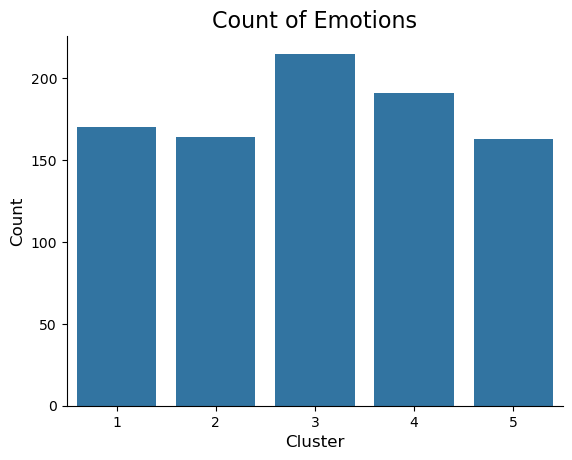

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Cluster')  # Use x='Cluster' to specify the column name
plt.ylabel('Count', size=12)
plt.xlabel('Cluster', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [71]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [73]:
# Zero crossing rate
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

# Root mean square
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

# Mel-Frequency Cepstral coefficient
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

# Combine all feature functions
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

# Apply data augmentation and extract its features
def get_features(path,duration=28, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset,mono=True)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [75]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


In [77]:
data_path.Path.shape[0]

903

In [79]:
import timeit
from tqdm import tqdm

# Extract the features.
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Cluster,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)     

1it [00:01,  1.32s/it]

0 audio has been processed


501it [04:27,  1.92it/s]

500 audio has been processed


903it [08:01,  1.88it/s]

Done
Time:  481.4303593000004


In [81]:
len(X), len(Y), data_path.Path.shape

(3612, 3612, (903,))

In [83]:
# Save the features in a CSV file
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,26523,26524,26525,26526,26527,26528,26529,26530,26531,Emotions
0,0.068848,0.152344,0.193359,0.201172,0.201172,0.148438,0.138672,0.117188,0.105957,0.098145,...,4.576486,-6.084824,0.972752,0.282738,-7.802341,-2.931611,-14.446407,-15.551273,-2.425961,1
1,0.090332,0.177734,0.224609,0.222168,0.218750,0.166992,0.157227,0.135254,0.125488,0.114746,...,5.281944,-1.115308,2.201428,-1.344719,-8.766788,-5.328629,-9.067704,-9.602626,-0.964996,1
2,0.077637,0.133789,0.183594,0.190918,0.191895,0.169434,0.144043,0.121094,0.097656,0.088867,...,4.207891,1.406096,14.699018,3.443357,-6.624914,-10.017124,-19.712032,-11.780302,1.844881,1
3,0.142090,0.209961,0.265625,0.233887,0.240723,0.222656,0.204590,0.193359,0.168457,0.166992,...,5.461617,11.566697,7.019311,0.363445,-1.898189,-4.825278,-8.484745,-7.578499,-0.116524,1
4,0.003906,0.005859,0.007812,0.010254,0.029297,0.031738,0.033203,0.031250,0.012695,0.010742,...,5.458148,1.508277,2.371638,4.184717,-0.171590,-7.751956,5.440473,-3.591162,4.499330,1


In [84]:
Emotions.shape

(3612, 26533)

In [87]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
26528        True
26529        True
26530        True
26531        True
Emotions    False
Length: 26533, dtype: bool


In [89]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
26528       False
26529       False
26530       False
26531       False
Emotions    False
Length: 26533, dtype: bool


(3612, 26533)

In [91]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
26528       0
26529       0
26530       0
26531       0
Emotions    0
Length: 26533, dtype: int64

In [93]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions

X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [95]:
Y

array([1, 1, 1, ..., 5, 5, 5], dtype=int64)

In [97]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [99]:
print(Y.shape)

X.shape

(3612, 5)


(3612, 26532)

In [101]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2889, 26532), (2889, 5), (723, 26532), (723, 5))

In [103]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [105]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2889, 26532), (2889, 5), (723, 26532), (723, 5))

In [109]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [111]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [123]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [125]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((2889, 26532, 1), (2889, 5), (723, 26532, 1), (723, 5))

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Dense


model = Sequential([
    Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    
    Conv1D(8,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.3),  # Add dropout layer after the fifth max pooling layer
    
    Flatten(),
    Dense(8,activation='relu'),
    BatchNormalization(),
    Dense(5,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 26532, 16)      │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26532, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13266, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 13266, 8)       │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13266, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6633, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6633, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 53064)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │       424,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,181 (1.62 MB)

 Trainable params: 425,117 (1.62 MB)

 Non-trainable params: 64 (256.00 B)

In [129]:
history=model.fit(x_traincnn, y_train,
                  epochs=30,
                  validation_data=(x_testcnn, y_test),
                  batch_size=16,
                  callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/30
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3014 - loss: 1.6409

181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.3023 - loss: 1.6393 - val_accuracy: 0.3555 - val_loss: 1.5200 - learning_rate: 0.0010
Epoch 2/30
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7798 - loss: 0.8471

181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.7803 - loss: 0.8459 - val_accuracy: 0.8368 - val_loss: 0.9016 - learning_rate: 0.0010
Epoch 3/30
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9658 - loss: 0.3501

181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9659 - loss: 0.3496 - val_accuracy: 0.9599 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 4/30
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9923 - loss: 0.1574

181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9923 - loss: 0.1573 - val_accuracy: 0.9710 - val_loss: 0.1915 - learning_rate: 0.0010
Epoch 5/30
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9941 - loss: 0.1003

181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.9941 - loss: 0.1002 - val_accuracy: 0.9834 - val_loss: 0.1425 - learning_rate: 0.0010
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 1.0000 - loss: 0.0565 - val_accuracy: 0.9765 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.9988 - loss: 0.0372 - val_accuracy: 0.9557 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9959 - loss: 0.0452 - val_accuracy: 0.9806 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 9/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9963 - loss: 0.0395 - val_accuracy: 0.9557 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 10/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9942 - loss: 0.0404 - val_accuracy: 0.9765 - val_loss: 0.0966 - learning_rate: 0.0010


In [131]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9824 - loss: 0.1366
Accuracy of our model on test data :  98.34024906158447 %


In [133]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


,Predicted Labels,Actual Labels
0,3,3
1,4,4
2,2,2
3,1,1
4,3,3
5,3,3
6,2,2
7,3,3
8,2,2
9,2,2


In [139]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
print(cm)
print(classification_report(y_test0, y_pred0))

[[150   3   2   0   1]
 [  0 121   0   0   0]
 [  1   1 162   1   0]
 [  0   0   0 140   0]
 [  3   0   0   0 138]]
              precision    recall  f1-score   support

           1       0.97      0.96      0.97       156
           2       0.97      1.00      0.98       121
           3       0.99      0.98      0.98       165
           4       0.99      1.00      1.00       140
           5       0.99      0.98      0.99       141

    accuracy                           0.98       723
   macro avg       0.98      0.98      0.98       723
weighted avg       0.98      0.98      0.98       723



In [141]:
# Save in the recommended .keras format
model.save("my_model.keras")

# Save in the legacy .h5 format
model.save("my_model.h5")

Here are the broad emotion names for each cluster based on the extracted data:

Cluster 1: Energetic & Bold (Boisterous, Confident, Passionate, Rousing, Rowdy)

Cluster 2: Happy & Playful (Amiable, Cheerful, Fun, Rollicking, Sweet)

Cluster 3: Melancholic & Reflective (Autumnal, Bittersweet, Brooding, Literate, Poignant, Wistful)

Cluster 4: Humorous & Quirky (Campy, Humorous, Silly, Witty, Wry, Whimsical)

Cluster 5: Intense & Dramatic (Aggressive, Fiery, Intense, Tense/Anxious, Visceral, Volatile)